#1. What is hive

Hive makes Hadoop look like a relational database.

Hive is a very powerful and simple way of quering data.

## Why Hive:

* Familiar SQL Syntax (HiveQL)
* Interactive
* Scalable (works with "big Data")
* Easy OLAP queries (Way easier than writing MapReduce in Java)
* Highly optimized.
* Highly extensible
  - User defined functions
  - Thrift server
  - JDBC / ODBC driver

## Why not hive:
* High latency (Not appropiate for OLTP, Online Transaction Processing).
* Stores data de-normalized:
  - even if it seems like a relational database, under the hood it is really all a string
* SQL is limited in what it can do (Spark, Pig allows more complex stuff)
* No transactions.
* No record-level updates, insers, deletes.

"Hive is a bunch of smoke and mirrors to make a cluster look like a database, but it really is not"


## HiveQL 
* Pretty much MySQL with some extentions
* For example: views
  - Can store results of a query into a "view", which subsequent queries can use as a table.

* Allows you to specify how structured data is stored and partitioned.



# 2. Use Hive to find the most popular movie.


1. Open ambari virtual machine
  - Open hortonworks
  - Open Ambari (browser)
  - Login

2. Go to Hive.
  - Grid icon
  - Hive View

3. Upload the data
  - Go to Upload Table tab
  - Choose your file and their type (CSV, Tab delimited format, etc...)
  - Edit anything you need from the table (Talbe names, Column names, etc...)
  - Click upload table.
  - Same process but with u.item, (remember to use the correct delimeter)

4. Query the data in the query editor
  - ```
CREATE VIEW topMovieIDs AS
SELECT movieID, COUNT(movieID) as ratingCount
FROM ratings
GROUP BY movieID 
ORDER BY ratingCount DESC;
#Since we want names we join the previous results with the movie title.
SELECT n.title, ratingCount
FROM topMovieIDs t JOIN names n ON t.movieID = n.movieID;
#This says we are gonna create a view called top movieIDs and its going to consists of the movieID and the sum of all the movieIDs and we call that count ratingCount.
# Basically we have two columns, movieID and ratingCount
# We have to tell it where to get the data from, (The ratings table)
# We group by movieID, this way our operation will count up all of the movies togheter for a given movie ID, (It will cluster all togheter, therefore you can count it)
# We order in desending order.
# then we join, to do this the FROM says we are gonna use two different talbes, topMovieIDs and names. NOTE: the t after topMovieIDs is the alias we give it (same with names n).
# we use the JOIN command ON the matching movieID
# So table "t" now also has a title column and we select it.
# then we select the ratingCount FROM the topMovieIDs view, (which is t)
```

5. Press execute

6. in the query write `DROP VIEW topmovieids;`


  
  


#3. How hive Works

## Schema On Read.
* Hive mantain a "metastore" that imparts a structure you define on the unstructured data that is stored on HDFS, etc...

Basically structured data define the data structure first then add the data, Hive takes the data and structure its laters.

NOTE: To import the data from command to hive:
```
CREATE TABLE ratings (
  userID INT,
  movieID INT,
  rating INT,
  time INT)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ´\t´
STORED AS TEXTFILE;

LOAD DATA LOCAL INPATH '${env:HOME}/ml-100k/u.data'
OVERWRITE INTO TABLE ratings;
```




## Where is the data?
Note: When you use LOAD DATA command from the CLI, that actually moves data from a distributed file system into Hive, (basically we say we want hive to manage this data from now on). THIS MEANS THAT YOU OWN THE DATA, IF YOU DELETE IT FROM HIVE, IT IS GONE FROM YOUR HDFS

This happens because if you have already really large datasets, you do not want another copy of it in your system.

The managed vs external tables:
  - External tables are useful when you want to share data with other applications/systems.
    + So you don't really own the data, (if you delete the data from hive, the data is still retained in the HDFS).
  




## Partitioning

If you have a massive dataset and your queries are only in certain part of the data, partitioning in hive optimizes this very well. (Eg. You have an international database, and you only want to take one country).

Another note: HIVE is not restricted to "common" data types, you can use things like STRUCT, where you have parts of certain data belong to certain types.


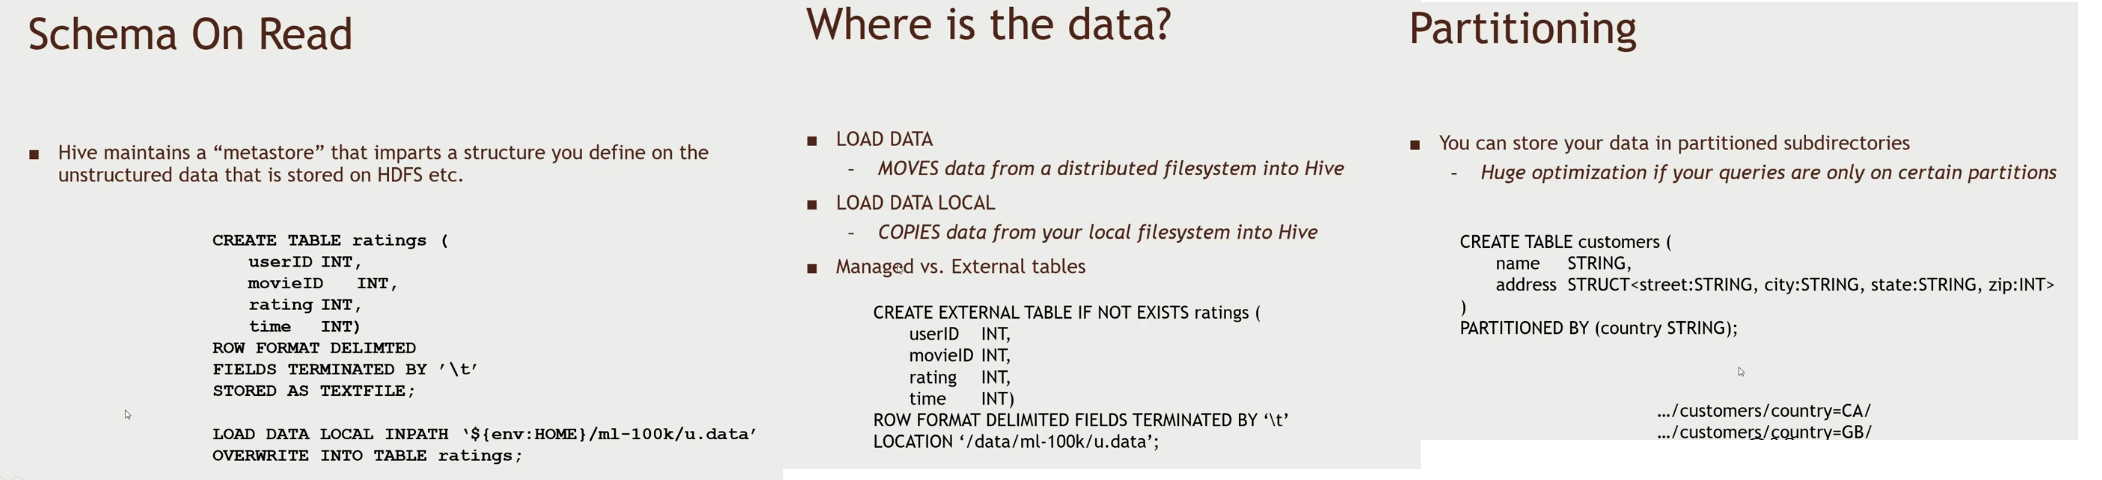

## Ways to use Hive

* Interactive via hive > prompt /(CLI)
* Saved query files
  - hive -f /somepath/queries.hql
* Through Amabari/Hue
* Through JDBC/ODBC server
* Through Thrift service
  -Rember, Hive is not suitable for OTLP (Online transaction)
* Via Oozie.

# 4. Use Hive to find the movie with the highest average rating.

Find the movie with the highest average rating.

* Hint: AVG() can be used on aggregated data, like COUNT() does.

* Extra: only consider movies with more than 10 ratings 

In [0]:
CREATE VIEW IF NOT EXISTS topRatedMovieIDs AS
SELECT movieID, AVG(rating) as ratingAverage, COUNT(movieID) as ratingCount
FROM ratings
GROUP BY movieID 
ORDER BY ratingAverage DESC; #Here we get the movieID and the average

#Since we want names we join the previous results with the movie title.
SELECT n.title, ratingAverage
FROM topRatedMovieIDs t JOIN names n ON t.movieID = n.movieID
WHERE ratingCount > 10;
#Here now we have movie name and Average


# Okay, literally you just list the columns you want in the VIEW,
# To filter you select the view and use WHERE "your condition"


SyntaxError: ignored

#6. Integrating MySQL to Hadoop.

NOTE: Hive makes hadoop look like a relational database, but it really is not under the hood.
BUt you can connect hadoop to an actual relational database, like MySQL.

## We use Sqoop

Sqoop is made to handle large datasets and import/export them to your hadoop cluster.

How it works:
When you export data from your database into hadoop, sqoop kicks off a bunch of mappers, and this mappers talk to the HDFS cluster and populate a table on HDFS.

To import the data, breaking down the code:
```
* sqoop import - we want to import data into the cluster
* connect jdbc:mysql//localhost/movielens - Connect to the database movielens, using the jdbc connector in the database running on your localhost.
* --driver com.mysql.jdbc.Driver - Sometimes if you dont give it a driver it gets mad, this way we avoid that.
* --table movies - Get the table that we want to move out of mysql into hdfs
```







If you wanted to skip the step of dumping the data into HDFS and just wanted to just place things in hive. you just add the line:
```
 *--hive-import
```




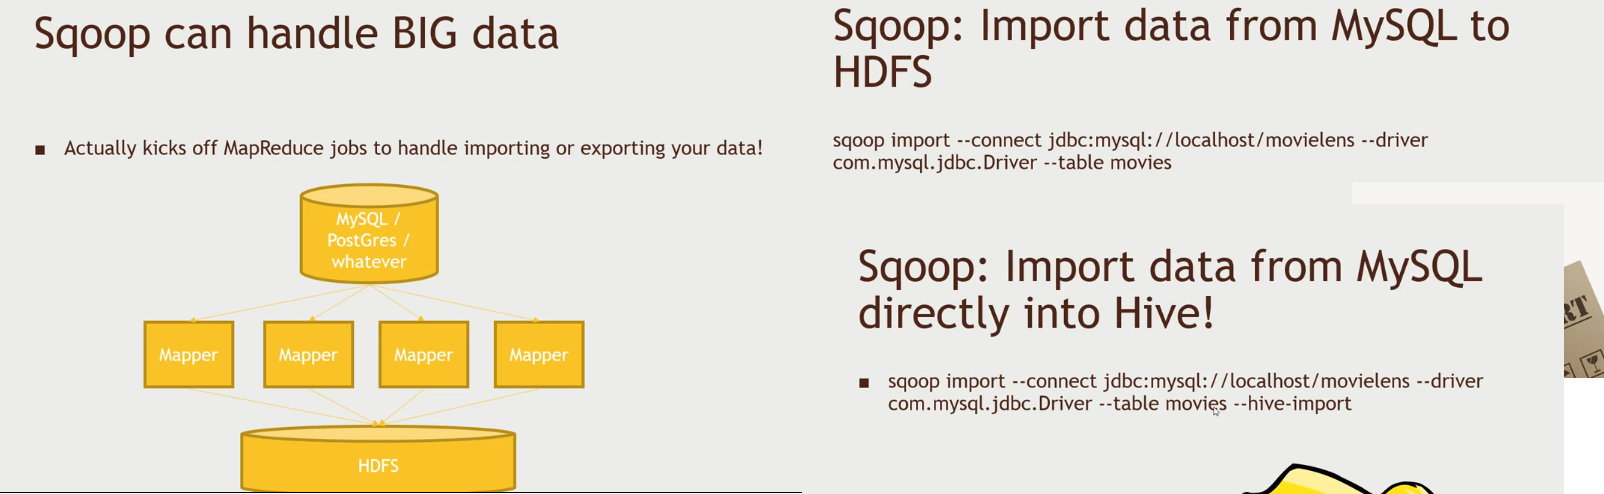

In hadoop you can do incremental imports.
* The check column which is basically a column that contains a timestamp or a sequence number 
* and you can provide a --last-value argument when you can say "i only want to import data where this columns value is greater than some given value"

This lets you do things like import a database, keep track where you left off and then the next time you run sqoop you can put that previous balue in your last value and continue where you left off.

With this you can keep your hive table in scync with your relational database over time.

You can also export data from hive into MySQL:
* Notes here, the `-m 1` part you remove it when working with a real cluster becasue it tells the program to just run one mapper.
* the `--table exported_movies --export-dir/...` the table in MySQL that this data will be saved into. NOTE: Make sure the table already exists, because SQOOP does not create them. You need to create a table with the appropiate columns ahead of time that matches up with whatever data is in your hive table
* `--export-dir...` Here you specify where will it be exported 
* `--input-fileds-terminated-by '\0001'` we specify the delimeter being used for the input fields in the hive table (By default it is 0001)



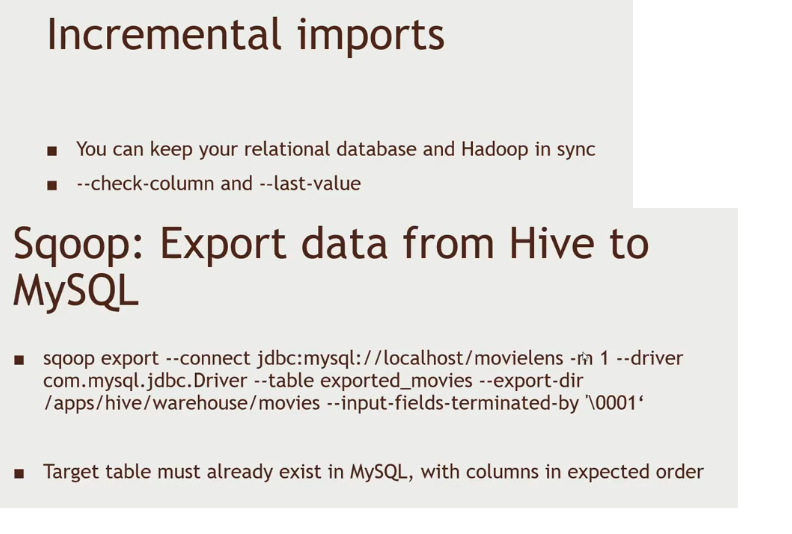

Activities:

* Import MovieLens data into MySQL database

* Import the movies to HDFS

* Import the movies into Hive

* Export the movies back into MySQL

#7. Install MySQL and import our movie data

## First we need to get data into our database.

1. Login into PuTTY
2. MySQL is already in hortonworks.
  * We use `mysql -u root -p` to get into MySQL, NOTE: You need to set up a password. (See image)

3. Create a movielens database (You are already inside mysql)
  * `create database movielens;`
  * exit from mysql and go into 'normal PuTTY'

4. get the data into PuTTY environment
  * `wget http://......`
  * now you should have a movielens.sql file in your environment.

5. Log back into mysql
6. NOTE: We need to tell MySQL the data is in UTF, so we use the following command `SET NAMES 'utf8';` and we also use: `SET CHARACTER SET utf8;`

7. Now we need to tell MySQL what database we are using. `use movielens;`
8. Import the data: `source movielens.sql;`
  * Note: `show tables` shows the data we have
  * Also `select * from movies limit 10;` or `describe ratings;` 

## Now we recreate what we did with hive, and figure out the top rated movies.

1.  `SELECT movies.title, COUNT(ratings.movie_id) AS ratingCount` This tells us that we're trying to create as output two columns, one that is the movie title and one that is the count of how many times that movie occurs in the ratings database.

2. `FROM movies` basically we tell them from where to get the movie titles,  NOTE: This are every line, (2 is line two) in the SQL query (this would be the little 'block' of code)
3. `INNER JOIN ratings` we join them, NOTE: Inner join returns matching rows
4. `ON movies.id = ratings.movie_id` we tell them to join by the movie id field (I think is the name of that field in both tables, should be the same)
5. `GROUP BY movies.title`
6. `ORDER BY ratingCount;` 



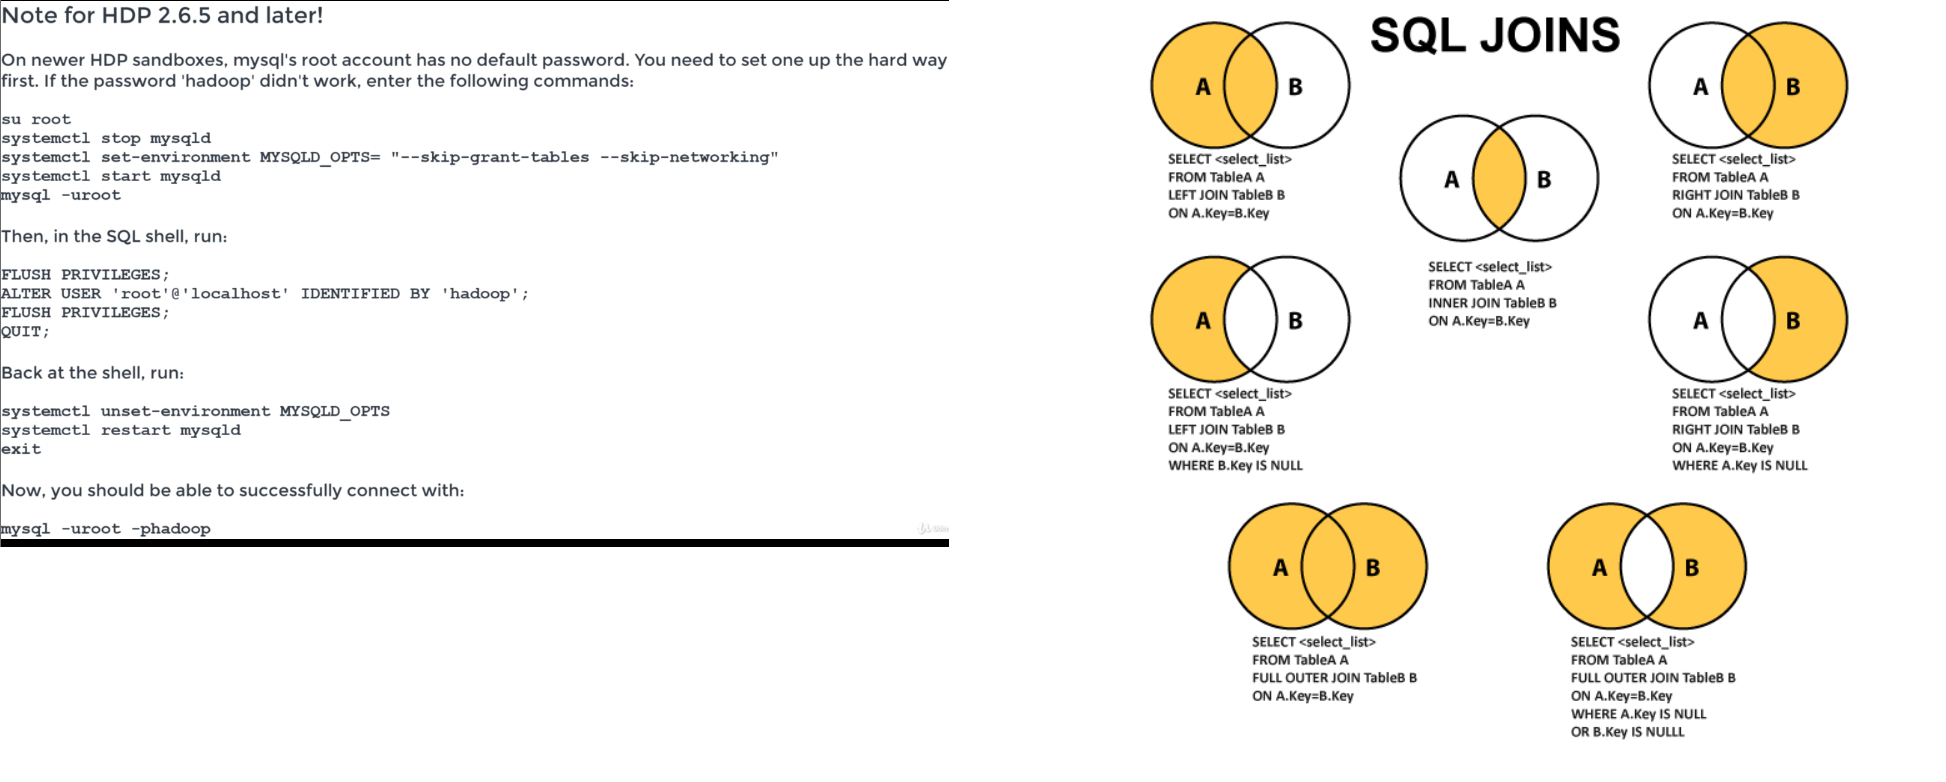

# 8. Use SQOOP to import data from MySQL to HFDSHive

## Grant privileges
1. Log into PuTTY -> MySQL (`mysql -u root -p` )
2. In MySQL `GRANT ALL PRIVILEGES ON movielens.* TO ''@'localhost';` NOTE: This is to grant privileges to localhost over the database. NOTE2: the .* in movielens is to grant the privileges over every table in movielens.
3. `exit` from sql

## Import SQOOP into HDFS

1. `sqoop import --connect jdbc:mysql://localhost/movielens --driver com.mysql.jdbc.Driver --table movies`
  * first you tell it to run the command on sqoop. 
  * import means that you will import data
  * We then connect through jdbc to a MySQL database on localhost, to the "movielens" database.
  * We set the driver we are gonna use to talk to our database.
  * We tell it to import only the movies table


2. If we go to Ambari, into our HDFS file system (usr->maria_dev) we see the movies directory that we created. 
  * The files inside the directory are part files that are distributed through the cluster (I think it is one part per parallel mapper used)
  * Note: you can click the file and it gives you a preview of the data.

## Import SQOOP into Hive directly
1. `sqoop import --connect jdbc:mysql://localhost/movielens --driver com.mysql.jdbc.Driver --table movies --hive-import` we literally just added a line of `--hive-import`

2. Go to ambari -> Hive view
  * Under default databases you can see the movies table with the id, title and release_date. (u.item)


# 9. Use Sqoop to export data from Hadoop to MySQL


1. Go to the ambari Hive View.
2. Go to files view -> apps directory (Note, in some distributions it is under the user folder)-> hive -> warehouse -> movies (our data).
  * Here is where the hive table is actually stored and managed by hive itself.

3. We need to make sure the table in MySQL exists ahead of time to recieve the data. Go to PuTTY -> `mysql -u root -p`

4. (in mysql) `use movielens;`
5. (in mysql) `CREATE TABLE exported_movies (id INTEGER, title VERCHAR(255), releaseData DATE);` Now we have a table set up to recieve the data we want.
6. `exit` (we exit mysql)
7. `sqoop export --connect jdbc:mysql://localhost/movielens -m 1 --driver com.mysql.jdbc.Driver --table exported_movies --export-dir /apps/hive/warehouse/movies --input-fields-termineted-by '\0001'`
  * run the command on SQOOP
  * we will export data
  * We tell it to connect to the movielens database on MySQL instance running on localhost
  * using 1 parallel process `-m 1`
  * using that driver
  * to the table exported_movies (which we just created) 
  * the `--export-dir ` is where it's going to get the data from on our cluster and push it into the exported_movies table in MySQL
  * We tell it how the data is delimited, in HDFS (hive?) they use ASCII delimiters 1,2,3 (which are like empty uncommon characters) that why we place the default 0001. (This is as to not interfere with any commas or whatever you have in your data)

We are done, to see if its there in MySQL

1. go to MySQL in PuTTY `mysql -u root -p`
2. (in MySQL) `select * from exported_movies limit 10;` 

# A few notes to remember when i come back:

1. Firstly you install Hortonworks HDP into a virtual machine, this allows you to have a Hadoop Distributed File System in your pc.

2. You go to ambari, this is the dashboard.

3. To work with many of this things you have to install PuTTY to communicate properly with HDFS.

4. Using a combination of PuTTY and Ambari you can use:
  1. Spark scripts
  2. Pig Scripts
  3. SQL scripts
  4. SQOOP
  5. Basically everything untill now is either one of those or combination of them.

NOTE: Remember that pretty much allways you have to make sure the databases you will write into actually exist. They will not be created for you. (Or if they exist that they have the adequate permissions, and proper formating)